In [186]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import sparse
import os
import random

# Read Data

## Amazon Fashion

In [187]:
path = 'Data/'
#Full data
# file_name = 'amazon_clothing_shoes_jewelry_data' 

#2m user above 5 ratings
# file_name = 'amazon_csj_2m'

#0.63m user above 5 ratings
# file_name = 'df_amazon_csj_with_styles_0.63m_u_above_5_rui' 

## MovieLens

In [188]:
path = 'Data/'
# Full data
# file_name = 'ml-25m'

# 2m subset
# file_name = '2m-ml'

# 0.7m subset
# file_name = 'ml_0.7_u_above_5'

## Time sorted ml 2m dataset

In [189]:
path = 'Data/datetime_sorted/'

#25m rows sorted per user on datetime
# file_name = 'ml-25m_sorted_u_dt'

#0.7m rows sorted per user on datetime
file_name = 'ml_07m_sorted'

In [190]:
df = pd.read_pickle(path + file_name)
df.head()

,user,item,rating,timestamp
20178786,131246,150,5.0,1996-06-25 19:51:50
20178815,131246,592,3.0,1996-06-25 19:51:50
20178814,131246,590,5.0,1996-06-25 19:51:50
20178806,131246,380,4.0,1996-06-25 19:51:50
20178796,131246,296,5.0,1996-06-25 19:51:50


In [191]:
df['user_id'] = df.user.astype('category').cat.codes
df['item_id'] = df.item.astype('category').cat.codes

## Leave users out 

In [192]:
def leave_users_out(full_data, leave_out):
    full_data['index'] = full_data.index
    user_index_df = full_data.groupby('user')['index'].apply(list)
    users = np.random.choice(list(user_index_df.index), leave_out, replace=False)
    users_indices = []
    
    for user in users:
        users_indices.extend(user_index_df.loc[user])
    
    sub_set = full_data.loc[users_indices]
    remaining = full_data.drop(users_indices)
    
    return remaining.drop(columns=['index']), sub_set.drop(columns=['index'])

In [193]:
# leftovers, new_df = leave_users_out(df, 4500)

# Data Exploration

First filtering active users and rated items with x or more ratings:

In [194]:
user_ratings = df.groupby('user')['rating'].count()
item_ratings = df.groupby('item')['rating'].count()
norpu = user_ratings.mean()
norpi = item_ratings.mean()
total_users = df.user.unique().size
total_items = df.item.unique().size
sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))

rows  698816 
#ratings 698816 
#ratings/user 155.29 
#ratings/item 35.43 
average rating 3.54 
#users  4500 
#items  19725 
sparse  0.99213 %


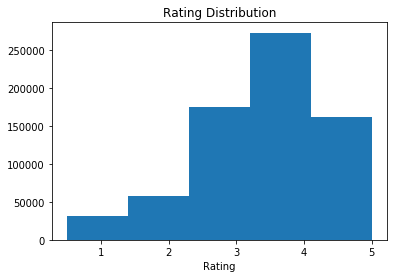

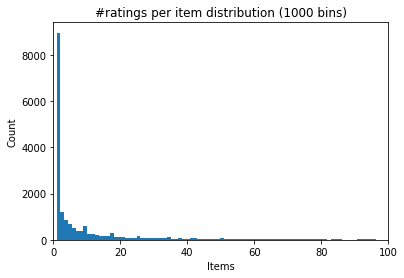

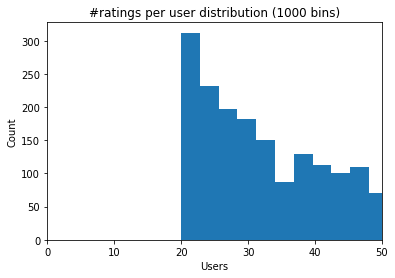

In [195]:
print('rows ', len(df), '\n#ratings', len(df[df['rating'] != 0]), '\n#ratings/user', round(norpu,2), '\n#ratings/item', round(norpi,2), '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), '\n#users ', df['user'].unique().size, '\n#items ', df['item'].unique().size, '\nsparse ', round(sparseness,5), '%')

df.hist(column='rating', bins=5, grid=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.xticks(range(1,6))
plt.savefig('Plots/Deliverables/rating_dist_ml')
plt.show()

plt.hist(item_ratings, bins = 2000)
plt.xlim([0,100])
plt.title('#ratings per item distribution (1000 bins)')
plt.xlabel('Items')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_item_dist_ml')
plt.show()

plt.hist(user_ratings, bins = 2000)
plt.xlim([0,50])
plt.title('#ratings per user distribution (1000 bins)')
plt.xlabel('Users')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_user_dist_ml')
plt.show()

---
# LSTM Model
Collaborative Filtering with Recurrent Neural Networks

- paper: https://arxiv.org/pdf/1608.07400.pdf
- code:https://github.com/rdevooght/sequence-based-recommendations (in Theano)

## Data Prep

Create 100 people **train df**

In [196]:
df_og = df

In [198]:
test_users = 500
df, test_df = leave_users_out(df_og, test_users)
df['item_id'] = df.item_id.astype('category').cat.codes
df['user_id'] = df.user_id.astype('category').cat.codes
n_items = len(df_og.item_id.unique())
print('total number of items:', n_items)
print('number of test users:', len(df.user_id.unique()) - test_users)
print('number of test users:', test_users)

total number of items: 19725
number of test users: 3500
number of test users: 500


---
### Train and Target sequences
Create the **sequences** from the item_ids per user (already sorted)

In [199]:
user_sequences_x = []
user_sequences_y = []

lengths = []
for u in df.user_id.unique():
    user_item_seq = np.array(df[df['user_id']==u]['item_id'])
    user_sequences_x.append(user_item_seq[:-1])
    user_sequences_y.append(user_item_seq[1:])
    lengths.append(len(user_item_seq))
print('number of sequences x:', len(user_sequences_x), 
      '\navg sequence length x:', np.average(lengths),
      '\nstd_dev sequence length x:', np.round(np.std(lengths),2))

number of sequences x: 4000 
avg sequence length x: 153.575 
std_dev sequence length x: 259.81


In [200]:
user_sequences_x[0]

array([144, 567, 565, 367, 284, 563, 159, 336, 331, 306, 316, 570, 568,
       417, 280, 440, 179,   9, 243, 288,   0, 108, 277,  20, 216,  33,
        46, 351,  49,  31, 154, 343, 463, 415, 354, 109, 418, 272, 564,
       167], dtype=int16)

In [201]:
user_sequences_y[0]

array([567, 565, 367, 284, 563, 159, 336, 331, 306, 316, 570, 568, 417,
       280, 440, 179,   9, 243, 288,   0, 108, 277,  20, 216,  33,  46,
       351,  49,  31, 154, 343, 463, 415, 354, 109, 418, 272, 564, 167,
       303], dtype=int16)

---
### Padding
**pad** the sequences (needed for rectangular tf.data.Dataset):
- add zeros if they are too short
- remove item ids from the beginning if they are too long

In [202]:
max_length = 250
padded_sequences_x = tf.keras.preprocessing.sequence.pad_sequences(user_sequences_x, maxlen=max_length, padding='post', truncating='pre')
padded_sequences_y = tf.keras.preprocessing.sequence.pad_sequences(user_sequences_y, maxlen=max_length, padding='post', truncating='pre')
print('number of sequences x:', padded_sequences_x.shape[0], 
      '\navg sequence length x:', np.average([i.shape[0] for i in padded_sequences_x]),
      '\nstd_dev sequence length x:', np.std([i.shape[0] for i in padded_sequences_x]))


number of sequences x: 4000 
avg sequence length x: 250.0 
std_dev sequence length x: 0.0


---
### Create Dataset
**create batch dataset**
- sequences_x inputs
- sequences_y actuals
- batches of size BATCH_SIZE

In [203]:
# One hot encoded input
# sequences_data_x = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_x, n_items)) 
# sequences_data_y = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_y, n_items)) 

#normal sequence input
sequences_data_x = tf.data.Dataset.from_tensor_slices(padded_sequences_x) 
sequences_data_y = tf.data.Dataset.from_tensor_slices(padded_sequences_y) 
dataset = tf.data.Dataset.zip((sequences_data_x, sequences_data_y))
dataset

<ZipDataset shapes: ((250,), (250,)), types: (tf.int32, tf.int32)>

In [204]:
for input_example, target_example in  dataset.take(1).as_numpy_iterator():
    print ('Input data: ', input_example)
    print ('Target data:', target_example)

Input data:  [144 567 565 367 284 563 159 336 331 306 316 570 568 417 280 440 179   9
 243 288   0 108 277  20 216  33  46 351  49  31 154 343 463 415 354 109
 418 272 564 167   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  

In [205]:
BATCH_SIZE = 100
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
for i, o in dataset.take(1).as_numpy_iterator():
    print('input:', i.shape, '\n\noutput:', o.shape)

input: (100, 250) 

output: (100, 250)


--- 
## Model Prep

**model architecture**

In [206]:
def build_model(n_items, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(n_items, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(units=rnn_units,
                             return_sequences=True,
                             stateful=True,
                             recurrent_initializer='glorot_uniform'),
        
        tf.keras.layers.Dense(n_items)
    ])
    return model

---
**build model**

In [207]:
embedding_dim = 100
rnn_units = 20

In [208]:
model = build_model(
n_items = n_items,
embedding_dim = embedding_dim,
rnn_units = rnn_units,
batch_size = BATCH_SIZE)

---
### Add Loss
<br>
one hot encode labels for dimensionality match of LSTM output
<br> 
**Added one hot encoding of the labels to match logits output after dense layer**

In [209]:
def loss(labels, logits):
    oh_labels = tf.keras.backend.one_hot(tf.dtypes.cast(labels, tf.int32), n_items)
    return tf.keras.losses.categorical_crossentropy(oh_labels, logits, from_logits=True)

model.compile(optimizer='Adagrad', loss=loss)

---
## Try Model

In [210]:
dataset.take(1)

<TakeDataset shapes: ((None, 250), (None, 250)), types: (tf.int32, tf.int32)>

In [211]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_preds = model(input_example_batch)
    print(example_batch_preds.shape, "# (batch_size, sequence_length, n_items)")

(100, 250, 19725) # (batch_size, sequence_length, n_items)


In [212]:
example_batch_loss = loss(target_example_batch, example_batch_preds)

In [213]:
example_batch_preds.shape

TensorShape([100, 250, 19725])

In [214]:
example_batch_loss.shape

TensorShape([100, 250])

---
**model summmary**

In [215]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (100, None, 100)          1972500   
_________________________________________________________________
lstm_2 (LSTM)                (100, None, 20)           9680      
_________________________________________________________________
dense_2 (Dense)              (100, None, 19725)        414225    
Total params: 2,396,405
Trainable params: 2,396,405
Non-trainable params: 0
_________________________________________________________________


---
## Train Model

---
**Configure Checkpoints**

In [216]:
# Directory where the checkpoints will be saved
checkpoint_dir = './rnn_train_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

---
**Fit Model**

In [217]:
epochs = 1
dataset

<BatchDataset shapes: ((None, 250), (None, 250)), types: (tf.int32, tf.int32)>

In [218]:
history = model.fit(dataset, epochs=epochs, callbacks=[checkpoint_callback])

Train for 40 steps
40/40 [==============================] - 402s 10s/step - loss: 9.8063


---
# Predict Sequences

## Restore Latest Checkpoints

In [219]:
tf.train.latest_checkpoint(checkpoint_dir)

'./rnn_train_checkpoints/ckpt_1'

In [220]:
model = build_model(n_items, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
                   
model.build(tf.TensorShape([1, None]))

In [221]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 100)            1972500   
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 20)             9680      
_________________________________________________________________
dense_3 (Dense)              (1, None, 19725)          414225    
Total params: 2,396,405
Trainable params: 2,396,405
Non-trainable params: 0
_________________________________________________________________


---
## Try Predictions

**Test user**

In [260]:
predictions_df = pd.DataFrame(columns=['user', 'pred_seq', 'true_seq'])

In [261]:
temperature = 1.0

for u in test_df.user_id.unique(): #Note: Can use multiprocessing module for this
    generated_predictions = []
    user_item_seq = np.array(test_df[test_df['user_id']==u]['item_id'])
    half_test_seq = user_item_seq[:int(len(user_item_seq)/2)]
    half_test_seq = half_test_seq.reshape(-1,1).transpose()
    other_half = user_item_seq[int(len(user_item_seq)/2):]

    #Predict
    for item in half_test_seq[0]:
        predictions = model(half_test_seq)
        predictions = tf.squeeze(predictions, 0)

        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        half_test_seq = tf.expand_dims([predicted_id], 0)
        generated_predictions.append(predicted_id)
        
    predictions_df = predictions_df.append({'user':u, 'pred_seq':generated_predictions, 'true_seq':other_half}, ignore_index=True)

In [262]:
predictions_df

,user,pred_seq,true_seq
0,1919,"[4431, 13638, 15464, 15169, 2662, 19610, 2634,...","[4985, 5780, 4900, 13866, 14362, 9564, 4788, 5..."
1,3921,"[4105, 10505, 3946, 237, 14781, 11681, 7047, 7...","[6060, 3586, 7090, 5931, 6196, 5775, 4360, 925..."
2,3905,"[13606, 4257, 9814, 2996, 11696, 9808, 8929, 1...","[366, 217, 485, 512, 346, 535, 565, 564, 197, ..."
3,532,"[4837, 5071, 16816, 17191, 5749, 7575, 18092, ...","[359, 567, 726, 465, 512, 425, 396, 366, 524, ..."
4,603,"[7319, 6927, 7408, 759, 1983, 3253, 4306, 3453...","[353, 442, 326, 279, 570, 49, 156, 145, 439, 4..."
...,...,...,...
495,3970,"[2451, 14345, 9291, 11159, 15553, 360, 13816, ...","[8757, 8286, 9091, 8943, 4933, 789, 9125, 6197..."
496,536,"[5458, 14719, 2041, 1072, 19462, 14731, 17613,...","[181, 283, 167, 494, 93, 153, 539, 459, 30, 21..."
497,2538,"[3383, 6179, 14307, 19562, 15105, 14753, 3339,...","[1001, 1174, 3082, 10000, 887, 2866, 0, 11588,..."
498,1385,"[446, 6212, 4046, 14170, 4901, 6749, 2604, 158...","[2403, 517, 818, 1253, 2309, 2128, 1784, 1783,..."


---
**Prediction Loop**

In [ ]:
def generate_seq_preds(model, start_input):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
print(generate_seq_preds(model, start_input=1))

# Appendix

In [ ]:
# oh_input = tf.keras.backend.one_hot(padded, n_items)
# e = tf.keras.layers.Embedding(n_items, 100, input_length=max_l)